In [1]:
import pandas as pd
from pathlib import Path
from hict.api.ContactMatrixFacet import ContactMatrixFacet
from hict.util.matrix_visualise import MatrixVisualise
import cooler
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.models import load_model
import glob
import matplotlib.colors as clr

# Setup constants and load models

In [2]:
img_height = 20
img_width = 20
local_path = 'D:/Study/HICT/HICT_Patterns/'
clr_map = clr.LinearSegmentedColormap.from_list('yarg', ['#e6e6e6','#000'], N=256)

centered_first = load_model("D:/Study/HICT/HICT_Patterns/exported_models/centered_first.keras", compile = False)
centered_second = load_model("D:/Study/HICT/HICT_Patterns/exported_models/centered_second.keras", compile = False)
centered_third = load_model("D:/Study/HICT/HICT_Patterns/exported_models/centered_third.keras", compile = False)

final_first = load_model("D:/Study/HICT/HICT_Patterns/exported_models/final_first.keras", compile = False)
final_second = load_model("D:/Study/HICT/HICT_Patterns/exported_models/final_second.keras", compile = False)
final_third = load_model("D:/Study/HICT/HICT_Patterns/exported_models/final_third.keras", compile = False)

# Create empty directories for temp files

In [3]:
def delete_temp_images(path):
    files = glob.glob(f'{path}/*')
    for f in files:
        os.remove(f)

chr = 'scf5'
resolution = 10000
dataset_path = f'{local_path}datasets/temp_images_{resolution//1000}'
unknown_images_path = f'{local_path}datasets/temp_images_{resolution//1000}/unknown'

if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

if not os.path.exists(unknown_images_path):
    os.mkdir(unknown_images_path)
delete_temp_images(unknown_images_path)

# Load matrix from source

In [4]:
#c = cooler.Cooler(f'data/atrop_ebre/atrop_ebre_4DN.mcool::/resolutions/{resolution}')
#matrix = c.matrix(balance=False).fetch(chr)

chunkFile = ContactMatrixFacet.get_file_descriptor(f'{local_path}data/arab_dongX_vs_mopti_2nd_try.hdf5')
ContactMatrixFacet.open_file(chunkFile)
ContactMatrixFacet.load_assembly_from_agp(chunkFile, Path(f'{local_path}data/mopti_female_assembly_2.agp'))
matrix = MatrixVisualise.get_matrix(chunkFile, 'scaffold_5', resolution, False)

# Create samples for detection from matrix main diagonal

In [5]:
src_matrix = np.log10(matrix+1)
max_value = np.nanmax(src_matrix)
min_value = np.nanmin(src_matrix)
for i in range(10, src_matrix.shape[0]-10):
        point = (i, i)
        point_area = src_matrix[point[1]-10:point[1]+10, point[0]-10:point[0]+10]
        plt.imsave(f'{unknown_images_path}/{chr}_{i*resolution}_{i*resolution}.png',  point_area, cmap=clr_map, vmax=max_value, vmin=min_value)

# Primary detection by samples from main diagonal only

In [6]:
detected_points = []

for path in os.listdir(unknown_images_path):
    img_path = os.path.join(unknown_images_path, path)
    with tf.device('/device:CPU:0'):
        img = tf.keras.utils.load_img(
            img_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions_cnn = np.array(centered_first(img_array)),
        predictions_cnn_2 = np.array(centered_second(img_array)),
        predictions_LeNet = np.array(centered_third(img_array)),
        predictions = (predictions_cnn[0] + predictions_cnn_2[0] + predictions_LeNet[0]) / 3

        score = tf.nn.softmax(predictions[0])

        if np.argmax(score) == 1:
          path_splited = path.split('_')
          detected_points.append(int(path_splited[1]))

print(len(detected_points))

2401


# Create samples from crosses of detected translocations on main diagonal

In [11]:
detected_images_path = f'{dataset_path}/detected'
if not os.path.exists(detected_images_path):
    os.mkdir(detected_images_path)
delete_temp_images(detected_images_path)

for i in detected_points:
    for j in detected_points:
        if i == j or i > j:
            continue
        point = (i//resolution, j//resolution)
        point_area = src_matrix[point[1]-10:point[1]+10, point[0]-10:point[0]+10]
        plt.imsave(f'{detected_images_path}/{chr}_{i}_{j}.png',  point_area, cmap=clr_map, vmax=max_value, vmin=min_value)

KeyboardInterrupt: 

# Final detection by samples from whole matrix

In [ ]:
detected_points = []

for path in os.listdir(detected_images_path):
    img_path = os.path.join(detected_images_path, path)
    with tf.device('/device:CPU:0'):
        img = tf.keras.utils.load_img(
            img_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions_cnn = np.array(final_first(img_array)),
        predictions_cnn_2 = np.array(final_second(img_array)),
        predictions_LeNet = np.array(final_third(img_array)),
        predictions = (predictions_cnn[0] + predictions_cnn_2[0] + predictions_LeNet[0]) / 3

        score = tf.nn.softmax(predictions[0])

        if np.argmax(score) == 1:
            path_splited = path.split('_')
            detected_points.append((int(path_splited[1]),int(path_splited[2].split('.')[0])))

print(len(detected_points))

# Remove points too close to each other

In [ ]:
import math

detected_points = sorted(detected_points, key=lambda element: element[0] + element[1])
new_points = []
i = 0
while i < len(detected_points):
    group = []
    point = detected_points[i]
    group.append(point)
    if i+1 < len(detected_points):
        while math.sqrt((detected_points[i+1][0] - point[0])**2 + (detected_points[i+1][1] - point[1])**2) \
                < 20 * resolution:
            group.append(detected_points[i+1])
            i+=1
            point = detected_points[i]
            if i+1 >= len(detected_points):
                break
    new_point = ((sum(map(lambda x: x[0], group)))//len(group), sum(map(lambda x: x[1], group))//len(group))
    new_points.append(new_point)
    i+=1

In [ ]:
with open(f'{local_path}data/ab_detected_rearrangements_ensemble_crossed_10.csv', mode='w') as output:
    output.write("chr,start,end\n")
    for i in detected_points:
        output.write(f"X,{i[0]},{i[1]}\n")

# Visualising results

KeyboardInterrupt: 

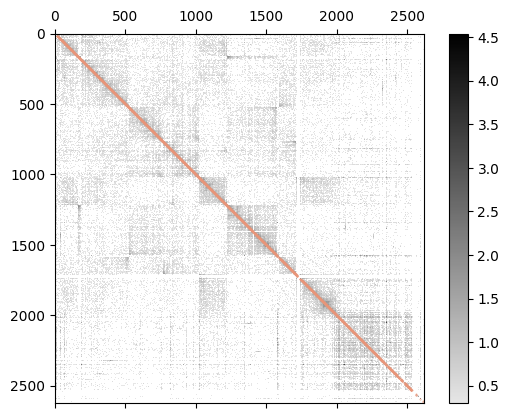

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(matrix+1), cmap=clr_map)
fig.colorbar(im)

trans = pd.read_csv(f'{local_path}data/ab_detected_rearrangements_ensemble_crossed_10.csv')
trans['start_res'] = trans.start // resolution
trans['end_res'] = trans.end // resolution
plt.scatter(trans.start_res, trans.end_res,s=0.1, c='#E9967A')
plt.savefig(f'{local_path}results_images/ab_trans_center_unbalanced_crossed_10k.png', dpi=1000)